In [15]:
import onnx

model = onnx.load("C:/Users/hanna/.insightface/models/curricularface/curricularface_model.onnx")


print("Original Outputs:", [output.name for output in model.graph.output])
# Remove the second output (shape (1, 1))
model.graph.output.remove(model.graph.output[1])
#
# Save the modified model
onnx.save(model, "C:/Users/hanna/Skola/Projektkurs/A-Modified-Pipeline-for-Face-Recognition/Curricular/curricularface_model_modified.onnx")

Original Outputs: ['output', '1079']


In [1]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

#First create handler with our own Adaface model
handler = insightface.model_zoo.get_model("C:/Users/hanna/.insightface/models/curricularface/curricularface_model_modified.onnx")

#Then use FaceAnalysis to extract face
app = FaceAnalysis(name='curricularface') # changed so that it uses Curricular, Adaface Instead of Arcface as feature extractor. 
app.prepare(ctx_id=0, det_size=(640, 640))

c:\Users\hanna\anaconda3\envs\insightface2_env\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hanna/.insightface\models\curricularface\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hanna/.insightface\models\curricularface\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hanna/.insightface\models\curricularface\curricularface_model_modified.onnx recognition ['batch_size', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hanna/.insightface\models\curricularface\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with option

In [17]:
image = cv2.imread("Images\img1.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert to RGB
features_one = app.get(image)

image_two = cv2.imread("Images\img2.jpeg")
image_two = cv2.cvtColor(image_two, cv2.COLOR_RGB2BGR)  # Convert to RGB
features_two = app.get(image_two)

C:\Users\hanna\Skola\Projektkurs\insightface\python-package\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


# Extract embeddings

In [18]:
# Extract embeddings from the features list
embeddings_one = np.array([face['embedding'] for face in features_one])
embeddings_two = np.array([face['embedding'] for face in features_two])

# Print the result
#print(embeddings_one)


similarity = handler.compute_sim(embeddings_one, embeddings_two)
print("similarity score: ", similarity)




similarity score:  0.7403629


## Create Inter-/Intraclass similarites 
This code requires a gpu, NVIDA based, which means it is limited in its current form.

In [2]:
import os
import cv2
import numpy as np
import insightface
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Initialize model
app = insightface.app.FaceAnalysis(name='curricularface')
app.prepare(ctx_id=0, det_size=(640, 640))

# Load AGEDB dataset (Assuming structured as 'dataset/{identity}/image.jpg')
dataset_path = r"C:\Users\hanna\Skola\Projektkurs\Projektkurs_Images\AgeDB"

identity_embeddings = {}

# Iterate over dataset
for identity in os.listdir(dataset_path):
    identity_path = os.path.join(dataset_path, identity)
    if os.path.isdir(identity_path):
        embeddings = []
        for img_name in os.listdir(identity_path):
            img_path = os.path.join(identity_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            faces = app.get(img)
            if faces:
                embeddings.append(faces[0]['embedding'])
        if embeddings:
            identity_embeddings[identity] = np.array(embeddings)

# Create intra-class and inter-class pairs
intra_similarities = []
inter_similarities = []

identities = list(identity_embeddings.keys())

for i, id1 in enumerate(identities):
    embeddings1 = identity_embeddings[id1]
    
    # Compute intra-class similarity
    for j in range(len(embeddings1)):
        for k in range(j + 1, len(embeddings1)):
            sim = 1 - cosine(embeddings1[j], embeddings1[k])
            intra_similarities.append(sim)

    # Compute inter-class similarity
    for id2 in identities[i + 1:]:  
        embeddings2 = identity_embeddings[id2]
        for emb1 in embeddings1:
            for emb2 in embeddings2:
                sim = 1 - cosine(emb1, emb2)
                inter_similarities.append(sim)


c:\Users\hanna\anaconda3\envs\insightface_v1\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\hanna\anaconda3\envs\insightface_v1\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hanna/.insightface\models\curricularface\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hanna/.insightface\models\curricularface\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hanna/.insightface\models\curricularface\curricularface_model_modified.onnx recognition ['batch_size', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hanna/.insightface\models\curricularface\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hanna/.insightface\models\curricula

Plot Intra- and Inter-Class Similarities

In [3]:
# Convert histograms to probability distributions
hist_intra, bins_intra = np.histogram(intra_similarities, bins=50, density=True)
hist_inter, bins_inter = np.histogram(inter_similarities, bins=50, density=True)

# Normalize histograms
hist_intra = hist_intra / np.sum(hist_intra)
hist_inter = hist_inter / np.sum(hist_inter)

# Compute Bhattacharyya coefficient
bc = np.sum(np.sqrt(hist_intra * hist_inter))
print(f"Bhattacharyya Coefficient: {bc}")


Bhattacharyya Coefficient: nan


c:\Users\hanna\anaconda3\envs\insightface_v1\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Compute Bhattacharyya Coefficient

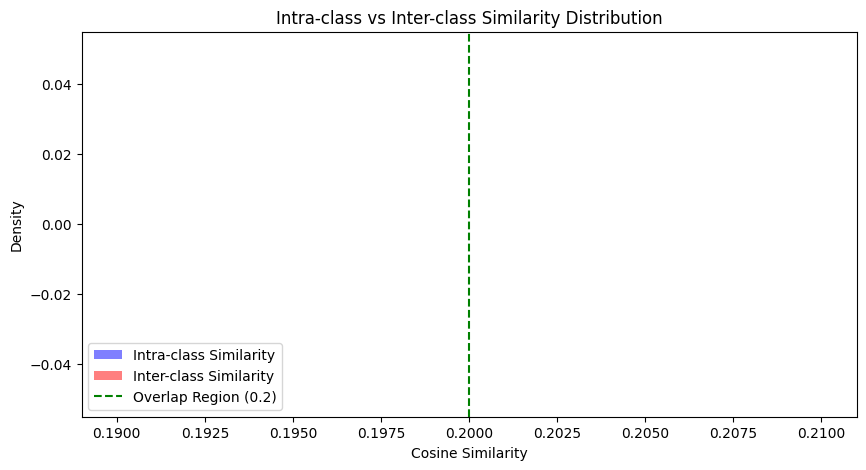

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(intra_similarities, bins=50, alpha=0.5, label="Intra-class Similarity", color='blue', density=True)
plt.hist(inter_similarities, bins=50, alpha=0.5, label="Inter-class Similarity", color='red', density=True)
plt.axvline(x=0.2, color='green', linestyle='dashed', label="Overlap Region (0.2)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.title("Intra-class vs Inter-class Similarity Distribution")
plt.show()
